In [2]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [3]:
data = pd.read_csv('mnist_train.csv')
data = data.values
labels = data[:, 0]
data = data[:,1:]
dataNorm = data/np.max(data)


print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [4]:
# step 1 : convert to tensor 
dataT = torch.tensor(dataNorm).float()
labels = torch.tensor(labels).long()

# step 2 : splitting the data 
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .1)

# step 3 : convert tensor datasets 
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels) 

# step 4 : dataloaders 
train_loader = DataLoader(train_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [5]:
def createTheMNISTNet(optimizer, learning_rate):

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()
            

            # input layer 
            self.input = nn.Linear(784, 64)

            # hidden layers
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            # output layer 
            self.output = nn.Linear(32, 10)

        def forward(self, X):
            
            X = f.relu(self.input(X))
            X = f.relu(self.fc1(X))
            X = f.relu(self.fc2(X))

            return torch.log_softmax(self.output(X), axis = 1)
        
    # create the model instance 
    net = mnistNet()

    # loss function 
    lossfun = nn.NLLLoss()

    # optimizer 
    optifun = getattr(torch.optim,optimizer)
    optimizer = optifun(net.parameters(), lr = learning_rate)

    return net, lossfun, optimizer 



            
            

In [6]:
def function2trainTheModel(optimizer, learning_rate):

    # number of epochs 
    numepochs = 60

    # create a new model 
    net, lossfun, optimizer = createTheMNISTNet(optimizer, learning_rate)

    # losses 
    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []


    for epochi in range(numepochs):
        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # matches 
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            batchAcc.append(accuracypct)
        
        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            matches = (torch.argmax(yHat, axis = 1) == y ).float()
            accuracypct = 100*torch.mean(matches)
            testAcc.append(accuracypct)

    return trainAcc, testAcc, losses, net


In [7]:
learning_rates = np.logspace(np.log(.0001), np.log(0.1), 6)
optimizers = ['SGD', 'RMSprop', 'Adam']

sgd_performance = []
rms_performance = []
adam_performance = []


for optimizer in optimizers:
    for learning_rate in learning_rates:
        test = function2trainTheModel(optimizer, learning_rate)[1]
        test_mean = np.mean(test[-10:])

        if optimizer == 'SGD':
            sgd_performance.append(test_mean)
        
        elif optimizer == 'RMSprop':
            rms_performance.append(test_mean)

        else:
            adam_performance.append(test_mean)


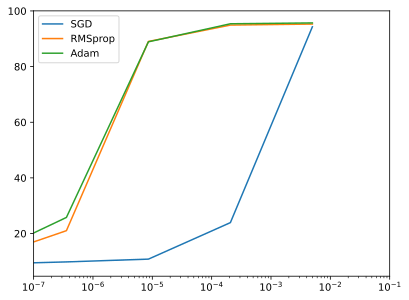

In [12]:
plt.plot(learning_rates, sgd_performance, label ='SGD')
plt.plot(learning_rates, rms_performance, label ='RMSprop')
plt.plot(learning_rates, adam_performance, label ='Adam')
plt.xscale('log')
plt.xlim([10**-7, 10**-1])
plt.legend()
plt.show()
